CLQCD组态的顺序是nmu = 4，nc_col = 3，nc_row = 3，nri = 2，nt ,nz , ny, nx
我们的数据格式 nt,nz,ny,nx,ndim,ns,ns,nc_row,nc_col

In [2]:
from mpi4py import MPI
import timeit
import numpy as np
import heat as ht
import torch

In [9]:

nc = 3
ndim = 4
nri = 2
nconf =1

In [102]:
def Get_ixyz(nx=8):
    Newx = np.zeros((nx,nx,nx),"i")
    for i in range(nx):
        for j in range(nx):
            for k in range(nx):
                if (i+j+k+3)%2 ==0 :
                    ix = i //2 + j*nx//2 + k * nx**2 // 2 + nx**3 / 2
                    Newx[k,j,i] = ix
                if (i+j+k+3)%2 ==1 :
                    ix = i //2 + j*nx//2 + k * nx**2 // 2
                    Newx[k,j,i] = ix
    return Newx

def test_u(u):
    tmp_u = u[0,0,0,0,0,0,0,:,:]
    tmp_udag = np.conjugate(np.transpose(tmp_u,(1,0)))
    print("u times u^dag = \n",np.dot(tmp_u,tmp_udag))
    tmp_inv = np.linalg.inv(tmp_u)
    print("u u^dag and u_inv \n",tmp_u,"\n",tmp_udag,"\n",tmp_inv)
    
def readlimedata(f,nt=128,nx=16):
    data = np.fromfile(f,dtype=">f8")
    num_data = nx**3 * nt * 3 * 3 * 4 * 2 
    return data[-num_data-18-17:-18-17]

In [141]:
path = "/CLQCD/configs/purgauge/aniso5beta30l24t144/"
files = [path + "bin%04i.dat"%i for i in range(1,100)]
nx,nt=8,96
nconf = len(files)
tmp_data = np.fromfile(files[0]).reshape(ndim,nc,nc,nri,nt,nx,nx,nx)
tmp_data2 = tmp_data[:,:,:,0,...]+1j*tmp_data[:,:,:,1,...]
#newx = Get_ixyz()
#newx = np.arange(nx**3,dtype="i").reshape(nx,nx,nx)
#tmp_data2 = tmp_data2[:,:,:,:,newx]
u = np.transpose(tmp_data2,(3,4,5,6,0,2,1)).reshape((nt,nx,nx,nx,4,1,1,3,3))

In [135]:
path = "/CLQCD/configs/clqcd/charm.b28.16_128.wo_stout.corrected/"
files = [path + "s1.0_cfg_%d.lime"%i for i in range(1,101)]
nx,nt=16,128
nconf = len(files)
tmp_data = np.reshape(readlimedata(files[0]),(nt,nx,nx,nx,4,3,3,2))
tmp_data2 = tmp_data[...,0]+1j*tmp_data[...,1]
u = tmp_data2.reshape((nt,nx,nx,nx,4,1,1,3,3))

In [145]:
tmp = u
plaqs = np.zeros((nt, nx, nx, nx, 1, 1,4,4),dtype="c16")
for inu in range(1,ndim):
    for imu in range(0,inu):
        plaq_1 =  np.einsum("...ij,...jk->...ik",tmp[...,inu,:,:,:,:],np.roll(tmp[...,imu,:,:,:,:],shift=-1,axis=(3-inu)))
        tmp_dag = np.conjugate(np.moveaxis(tmp,-1,-2))
        plaq_2 = np.einsum("...ij,...jk->...ik",np.roll(tmp_dag[...,inu,:,:,:,:],shift=-1,axis=(3-imu)),tmp_dag[...,imu,:,:,:,:])
        plaqs[...,inu,imu] = np.einsum("...ij,...ji->...",plaq_1,plaq_2)

测试梁剑的函数

In [127]:
lOfI = {}
lOfI['x'] = 3
lOfI['y'] = 2
lOfI['z'] = 1
lOfI['t'] = 0
def plaq_general_1(xdir_, dir1_="x", dir2_="y"):
    tmp = np.einsum('...ij,...jk',xdir_[dir1_],np.roll(xdir_[dir2_],-1,lOfI[dir1_]))
    tmp = np.einsum('...ij,...jk',tmp,np.roll(xdir_[dir1_],-1,lOfI[dir2_]).transpose((0,1,2,3,5,4)).conjugate())
    tmp = np.einsum('...ij,...jk',tmp,xdir_[dir2_].transpose((0,1,2,3,5,4)).conjugate())
    return tmp
def plaq(x, dir1_="x", dir2_="y"):
    xdir_ = {}
    xdir_['x'] = x[...,0,:,:]
    xdir_['y'] = x[...,1,:,:]
    xdir_['z'] = x[...,2,:,:]
    xdir_['t'] = x[...,3,:,:]   
    tmp = plaq_general_1(xdir_, dir1_, dir2_)
    tmp = np.sum(tmp, (0,1,2,3))
    return np.einsum('ii', tmp)/(nx**3*nt*3)
result = plaq(np.squeeze(u))

In [162]:
import gauge

In [163]:
clqcd = gauge.gauge(nt=96,nx=8)
plaq = []

In [165]:
for i in files:
    clqcd.ReadClqcdConf(i)
    clqcd.CalcPlaq()
    plaq.append(np.average(clqcd.plaq,0))

In [167]:
plaq = np.array(plaq)

In [168]:
plaq.shape

(99, 4, 4)

In [188]:
Corr = [np.average(plaq * np.roll(plaq,-i,0),0)-np.average(plaq,0)*np.average(np.roll(plaq,-i,0),0) for i in range(30)]
Corr = np.real(np.array(Corr))

In [189]:
Corr = Corr / np.expand_dims(Corr[0,...],0)

/home/guilongcheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [190]:
tau = 1/2 + np.sum(Corr,0)

In [191]:
tau

array([[       nan,        nan,        nan,        nan],
       [1.02487222,        nan,        nan,        nan],
       [6.38599832, 1.62148669,        nan,        nan],
       [1.16069463, 0.54522876, 2.44906111,        nan]])

In [175]:
import matplotlib.pyplot as plt

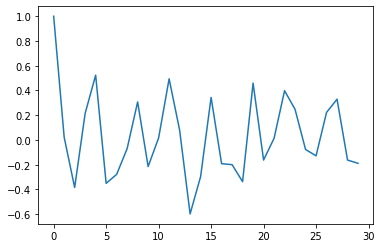

In [183]:
plt.plot(np.real(Corr[:,2,1]))